# Market Basket Analysis - Groceries

## Tarefa:
- Esse projeto consiste em uma análise das vendas de supermercados com o objetivo de encontrar padrões no comportamento dos consumidores, buscando determinar quais são os produtos mais comprados, quando são comprados e quais deles são mais comprados em conjunto. Dessa forma será possível gerar insights que podem orientar a tomada de decisão visando maior desempenho dos supermercados.
- Os dados brutos foram obtidos na plataforma Kaggle, através do link: https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset.
- Os dados possuem licença de uso GPL 2.

## 1 - Preparação do Ambiente de Trabalho

In [2]:
# Importação de pacotes
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import efficient_apriori
from efficient_apriori import apriori

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Carregando os dados
data = pd.read_csv('data/Groceries_dataset.csv')

## 2 - Conhecendo os Dados

In [4]:
# Amostra dos dados
data.head()

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [5]:
# Estrutura dos dados
data.shape

(38765, 3)

In [6]:
# Tipos dos dados
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


## 3 - Tratamento dos Dados

### 3.1 - Tratamento de Valores Ausentes

In [7]:
# Valores ausentes
data.isna().sum()

Member_number      0
Date               0
itemDescription    0
dtype: int64

>Não há valores ausentes a serem tratados.

### 3.2 - Tipos de Dados

In [8]:
# Conversão de tipos de dados
data['Date'] = pd.to_datetime(data['Date'])
data['itemDescription'] = data['itemDescription'].astype('string')

In [9]:
# Tipos de dados após conversão
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Member_number    38765 non-null  int64         
 1   Date             38765 non-null  datetime64[ns]
 2   itemDescription  38765 non-null  string        
dtypes: datetime64[ns](1), int64(1), string(1)
memory usage: 908.7 KB


### 3.3 - Preparação dos dados

In [10]:
# Criação de colunas com dia, mês, ano e dia da semana de uma compra
data['year'] = pd.DatetimeIndex(data['Date']).year
data['month'] = pd.DatetimeIndex(data['Date']).month
data['month_name'] = data['Date'].dt.month_name()
data['day'] = pd.DatetimeIndex(data['Date']).day
data['dow'] = data['Date'].apply(lambda valor : valor.weekday())
data['dow_name'] = data['Date'].dt.day_name()

In [11]:
# Criando uma coluna para conter 'order_id' fictício, de forma a facilitar a junção de registros de compras feitas pelo mesmo 
# cliente no mesmo dia. Assim, supõe-se que itens comprados no mesmo dia pelo mesmo consumidor façam parte de uma mesma compra.
data['order_id'] = data['Member_number'].astype('string').map(str) + data['day'].astype('string') + data['month'].astype('string') + data['year'].astype('string')

In [12]:
# Amostra dos dados após as modificações
data.head()

,Member_number,Date,itemDescription,year,month,month_name,day,dow,dow_name,order_id
0,1808,2015-07-21,tropical fruit,2015,7,July,21,1,Tuesday,18082172015
1,2552,2015-05-01,whole milk,2015,5,May,1,4,Friday,2552152015
2,2300,2015-09-19,pip fruit,2015,9,September,19,5,Saturday,23001992015
3,1187,2015-12-12,other vegetables,2015,12,December,12,5,Saturday,118712122015
4,3037,2015-01-02,whole milk,2015,1,January,2,4,Friday,3037212015


In [13]:
# Tipos de dados após modificações
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Member_number    38765 non-null  int64         
 1   Date             38765 non-null  datetime64[ns]
 2   itemDescription  38765 non-null  string        
 3   year             38765 non-null  int64         
 4   month            38765 non-null  int64         
 5   month_name       38765 non-null  object        
 6   day              38765 non-null  int64         
 7   dow              38765 non-null  int64         
 8   dow_name         38765 non-null  object        
 9   order_id         38765 non-null  string        
dtypes: datetime64[ns](1), int64(5), object(2), string(2)
memory usage: 3.0+ MB


## 4 - Estatísticas Descritivas

### 4.1 - Ítens mais vendidos

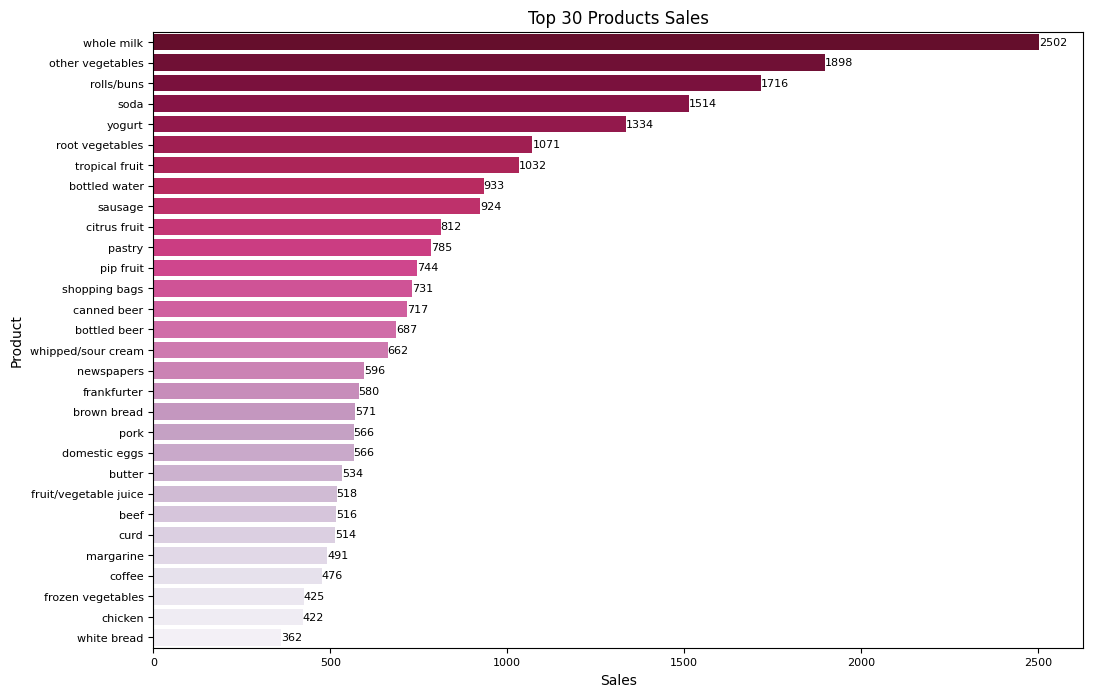

In [14]:
# Plot

# Dados para o plot: Número de compras por itemDescription
df1 = data.itemDescription.value_counts().reset_index().rename(columns = {'index':'item', 'itemDescription':'sales'})
df1 = df1.sort_values(by = 'sales', ascending = False)
df1 = df1[0:30]

# Gráfico
plt.figure(figsize = (12,8))
ax = sns.barplot(df1, x = df1['sales'], y = df1['item'], orient = 'h', palette = 'PuRd_r')
plt.title('Top 30 Products Sales', fontsize = 12)
plt.ylabel('Product', fontsize = 10)
plt.xlabel('Sales', fontsize = 10)
plt.yticks(fontsize = 8)
plt.xticks(fontsize = 8)
plt.bar_label(ax.containers[0], fontsize = 8)

plt.show()

- **Interpretações:**
- O leite integral é o produto mais vendido;
- A carne mais vendida é a linguiça, possivelmente pelo baixo preço. Carnes de porco, boi e frango, respectivamente, aparecem em seguida;
- Cervejas de lata e de garrafa possuem números semelhantes no que diz respeito à venda;
- O pão integral possui um número de vendas significativamente maior se comparado ao pão comum (mais de 57%).

### 4.2 - Dia da semana com mais vendas para cada um dos 30 produtos mais vendidos

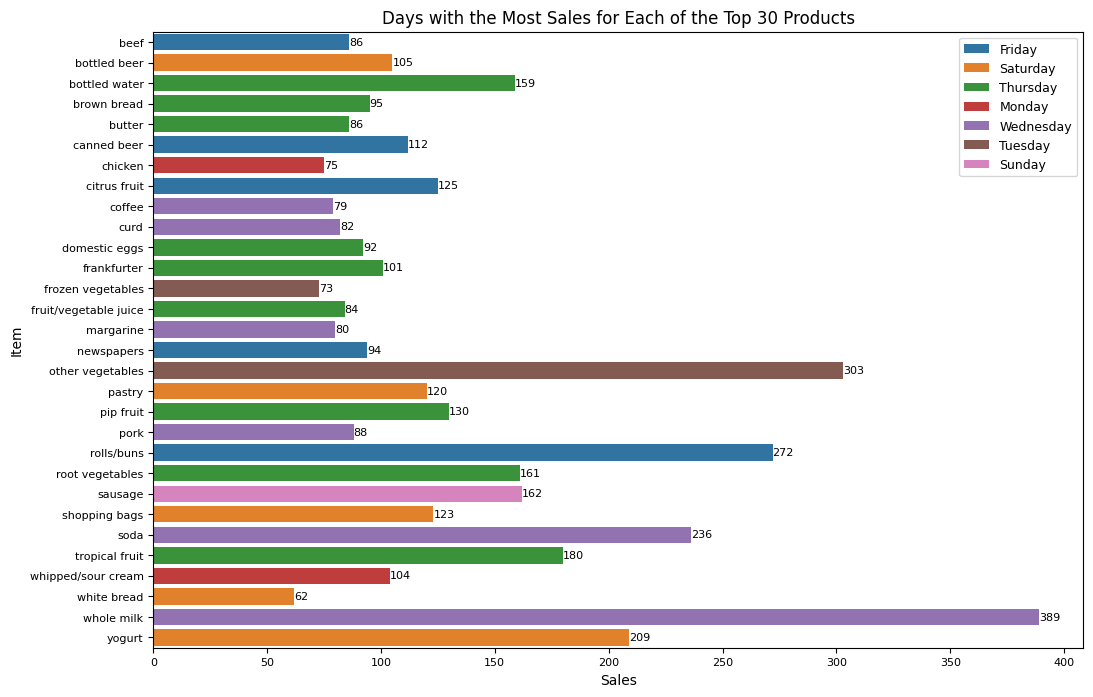

In [15]:
# Plot

# Dados para o plot: Vendas por item em cada dia da semana
df2 = count_products_dow = data.groupby(['itemDescription', 'dow', 'dow_name']).size().reset_index(name = 'products_sold')
df2 = df2.sort_values(by=['itemDescription', 'dow'])
df2 = df2.groupby(['itemDescription', 'dow_name'])['products_sold'].aggregate(np.max).reset_index()
idx = df2.groupby('itemDescription')['products_sold'].idxmax()
df2 = df2.loc[idx].reset_index(drop=True)

rows = df1[0:30]['item'].tolist()
df2 = df2[df2['itemDescription'].isin(rows)]


# Gráfico
plt.figure(figsize = (12, 8))
ax = sns.barplot(df2, x = df2['products_sold'], y = df2['itemDescription'], hue = df2['dow_name'], dodge=False)
plt.title('Days with the Most Sales for Each of the Top 30 Products', fontsize = 12)
plt.ylabel('Item', fontsize = 10)
plt.xlabel('Sales', fontsize = 10)
plt.yticks(fontsize = 8)
plt.xticks(fontsize = 8)
for i in ax.containers:
    ax.bar_label(i, fontsize=8)
plt.legend(loc = 1, fontsize = 9)

plt.show()

- **Interpretações:**
- Com relação às carnes, os dias com mais compras de cada tipo são diferentes, o que faz sentido pois geralmente as pessoas tendem a consumir determidados tipos de carne em momentos específicos durante a semana. Frango é mais comprado às segundas-feiras, carne de porco é mais comprada às quartas-feiras, carne bovina é mais comprada às sextas-feiras e linguiças são mais compradas aos domingos;
- Cervejas são mais compradas às sextas-feiras e sábados, o que faz sentido pois é intuitivo o maior consumo de álcool aos finais de semana;
- Produtos de consumo diário em grande parte são mais comprados a partir da metade da semana, como frutas, vegetais, sucos, ovos, água e pães.

### 4.3 - Vendas por dia da semana

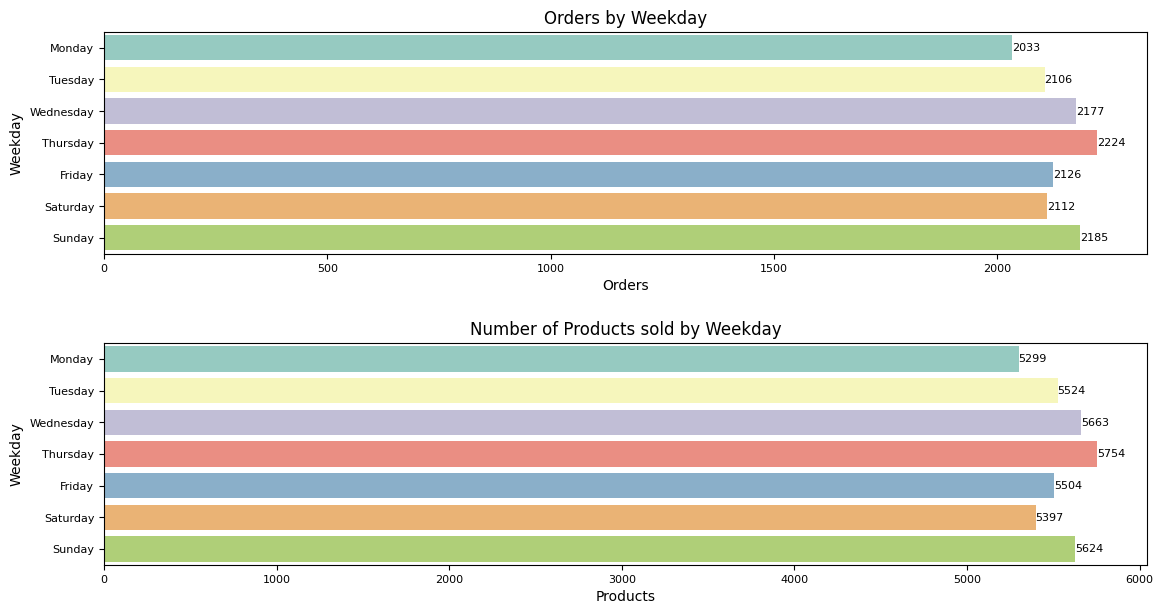

In [16]:
# Plot

# Dados para o primeiro plot: Contagem do número de vendas por dia da semana
df3 = data.groupby(['order_id', 'dow', 'dow_name']).agg('count')
df3 = df3.value_counts(subset = ['dow', 'dow_name']).reset_index().rename(columns = {0 : 'orders'}).sort_values(by='dow')

# Gráfico 1
plt.figure(figsize = (12, 6.5))
plt.subplot(2, 1, 1)
ax1 = sns.barplot(df3, x = df3['orders'], y = df3['dow_name'], orient = 'h', palette = 'Set3')
plt.title('Orders by Weekday', fontsize = 12)
plt.ylabel('Weekday', fontsize = 10)
plt.xlabel('Orders', fontsize = 10)
plt.yticks(fontsize = 8)
plt.xticks(fontsize = 8)
plt.bar_label(ax1.containers[0], fontsize = 8)


# Dados para o segundo plot: Contagem do número de vendas por dia da semana
df4 = data[['dow', 'dow_name']].value_counts().reset_index().rename(columns = {0 : 'products_sold'}).sort_values(by='dow')

# Gráfico 2
# plt.figure(figsize = (12,2.5))
plt.subplot(2, 1, 2)
ax2 = sns.barplot(df4, x = df4['products_sold'], y = df4['dow_name'], orient = 'h', palette = 'Set3')
plt.title('Number of Products sold by Weekday', fontsize = 12)
plt.ylabel('Weekday', fontsize = 10)
plt.xlabel('Products', fontsize = 10)
plt.yticks(fontsize = 8)
plt.xticks(fontsize = 8)
plt.bar_label(ax2.containers[0], fontsize = 8)

plt.tight_layout(pad = 2)
plt.show()

- **Interpretações:**
- O maior número de prudutos comprados tanto individualmente quanto em conjunto (cestas), de acordo com os dados é na quarta-feira. Possivelmente é um resultado impulsionado pelo elevado número de compras de leite, que na quarta-feira também é elevado;
- Às segundas-feiras há o menor número de cestas e produtos vendidos, o que faz sentido se analisado o resultado anterior que indica que poucos produtos são muito comprados na segunda-feira.

### 4.4 - Número de produtos vendidos por ano

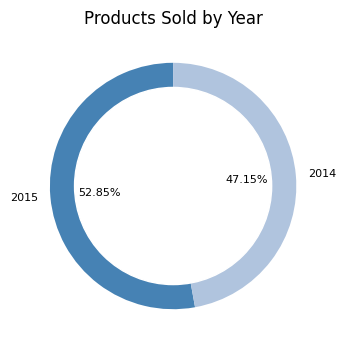

In [17]:
# Plot

# Dados para o plot: Contagem de produtos vendidos por ano
df5 = data.year.value_counts().reset_index().rename(columns = {'index' : 'Year', 'year' : 'products_sold'})

# Gráfico
plt.figure(figsize=(4,4))
plt.pie(df5['products_sold'], labels = df5['Year'], autopct='%.2f%%', colors=['steelblue', 'lightsteelblue'], startangle=90, 
        textprops={'fontsize': 8})
plt.title('Products Sold by Year')
p = plt.gcf()
ax1 = p.gca().add_artist(plt.Circle( (0,0), 0.8, color='white'))

plt.show()

- **Interpretações:**
- Em 2015 houve mais vendas que em 2014, o que indica uma evolução do negócio.

### 4.5 - Número de produtos vendidos por dia da semana anualmente

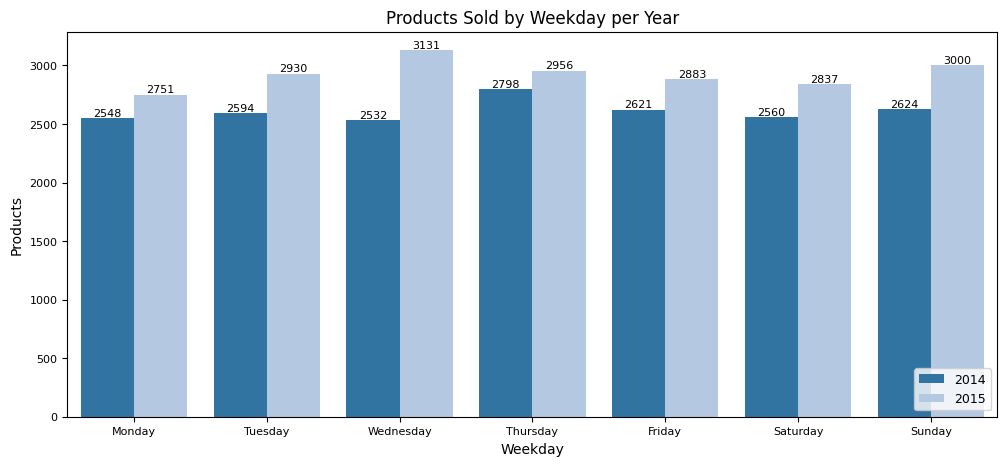

In [18]:
# Dados para o plot: Dataframe contendo o número de produtos vendidos por dia da semana para cada ano
df6 = data[['dow', 'dow_name', 'year']].groupby(['dow', 'dow_name', 'year']).size().reset_index(name = 'sales')

# Gráfico
plt.figure(figsize = (12, 5))
ax = sns.barplot(df6, x = df6['dow_name'], y = df6['sales'], hue = df6['year'], palette = 'tab20')
plt.title('Products Sold by Weekday per Year', fontsize = 12)
plt.xlabel('Weekday', fontsize = 10)
plt.ylabel('Products', fontsize = 10)
plt.yticks(fontsize = 8)
plt.xticks(fontsize = 8)
for i in ax.containers:
    ax.bar_label(i, fontsize=8)
plt.legend(loc = 4, fontsize = 9)    

plt.show()

- **Interpretações:**
- O crescimento no número de vendas de 2014 para 2015 foi alcançado juntamente com o aumento diário das vendas. Analisando o número de vendas por dia da semana, houve aumento em todos os dias da semana de 2014 para 2015, ou seja, esse crescimento anual não foi provocado por um crescimento pontual no que diz respeito a um dia específico da semana, mas sim um movimento conjunto e mais sólido.

### 4.6 - Número de produtos vendidos por mês anualmente

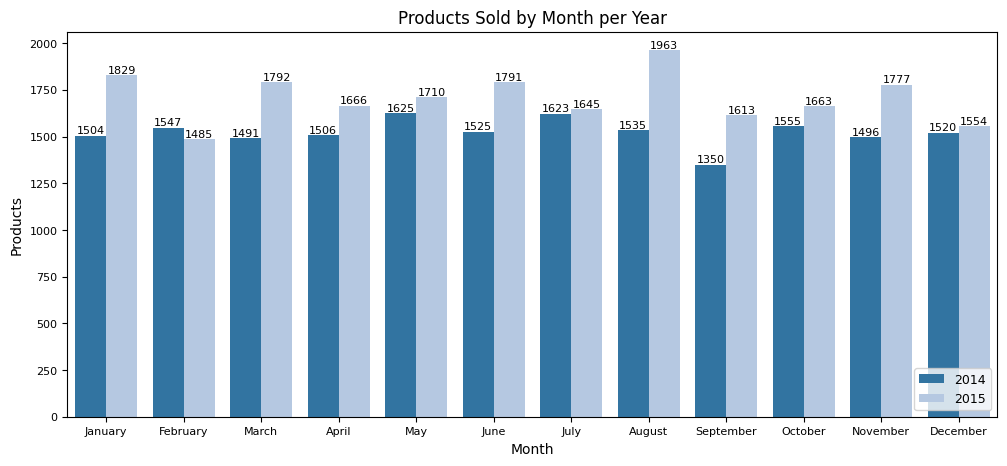

In [19]:
# Dados para o plot: Dataframe contendo o número de vendas por mês para cada ano
df7 = data[['month', 'month_name', 'year']].groupby(['month', 'month_name', 'year']).size().reset_index(name = 'sales')

# Gráfico
plt.figure(figsize = (12, 5))
ax = sns.barplot(df7, x = df7['month_name'], y = df7['sales'], hue = df7['year'], palette = 'tab20')
plt.title('Products Sold by Month per Year', fontsize = 12)
plt.xlabel('Month', fontsize = 10)
plt.ylabel('Products', fontsize = 10)
plt.yticks(fontsize = 8)
plt.xticks(fontsize = 8)
for i in ax.containers:
    ax.bar_label(i, fontsize=8)
plt.legend(loc = 4, fontsize = 9)

plt.show()

- **Interpretações:**
- Com exceção do mês de fevereiro, todos os meses de 2015 apresentaram mais vendas que seus respectivos em 2014. Isso mais uma vez indica um movimento conjunto e sólido no aumento do número de vendas. Pode ser interessante realizar uma análise mais profunda buscando identificar o mitivo da redução nas vendas no mês de fevereiro.

## 5 - Análise com o Algoritmo Apriori

In [20]:
# Preparação dos dados para aplicação do algoritmo

# Agrupando por order_id e product_id
order_grouped = pd.DataFrame(data.groupby('Member_number')['itemDescription'])

# Lista vazia para armazenar produtos
produtos = []

# Preenchimento da lista com os produtos
for i in range(len(order_grouped[0])):
    produtos.append(list(order_grouped.iloc[i][1]))

# Ajustes
produtos2 = produtos
order2 = order_grouped[0]

# Preparação do DataFrame
df_prod = pd.DataFrame({'Order_ID' : order2, 'Products' : produtos2})

prod_sales = [tuple(i) for i in df_prod['Products'].tolist()]

In [25]:
# Aplicação do Algoritmo
itemsets_ap, rules_ap = apriori(prod_sales, min_support = 0.085, min_confidence = 0.2)

In [26]:
# Criação de um DataFrame para conter os dados

# Dicionário vazio
dict1 = {}

# Listas vazias
list_rules = []
list_support = []
list_confidence = []

# Iteração para preencher as listas com os valores de interesse
for rule in rules_ap:
    list_rules.append(rule.lhs[0] + ' --> ' + rule.rhs[0])
    list_support.append(rule.support*100)
    list_confidence.append(rule.confidence*100)

# Preenchimento do dicionário com os as listas preenchidas anteriormente
dict1['Association Rule'] = list_rules
dict1['Support'] = list_support
dict1['Confidence'] = list_confidence

# Criação do Dataframe
df8 = pd.DataFrame.from_dict(dict1)
indice=df8.groupby('Support')['Confidence'].idxmax()
df8 = df8.loc[indice].reset_index(drop=True)
df8

,Association Rule,Support,Confidence
0,bottled beer --> whole milk,8.542842,53.796446
1,pip fruit --> whole milk,8.696768,50.977444
2,canned beer --> whole milk,8.722422,52.795031
3,tropical fruit --> rolls/buns,8.825038,37.760703
4,root vegetables --> rolls/buns,9.081580,39.377086
5,pastry --> whole milk,9.107234,51.300578
6,shopping bags --> whole milk,9.132889,54.268293
7,citrus fruit --> whole milk,9.235505,49.792531
8,sausage --> other vegetables,9.286814,45.080946
9,bottled water --> other vegetables,9.389430,43.937575


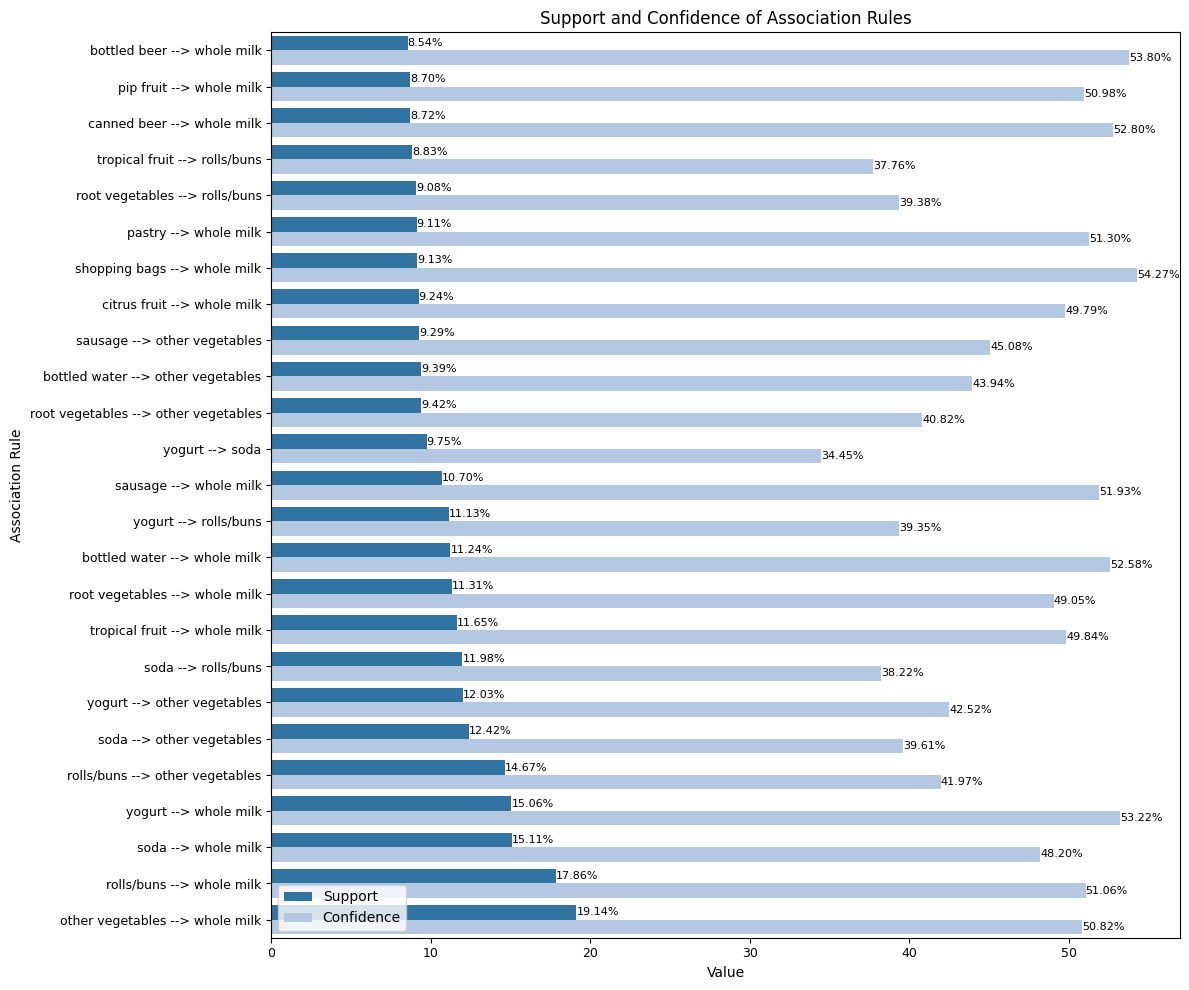

In [30]:
# Plot para uma melhor visualização das dimensões dos valores encontrados para as regras de associação

fig, ax1 = plt.subplots(figsize=(12,10))
tidy = df8.melt(id_vars = 'Association Rule').rename(columns=str.title)
sns.barplot(y = 'Association Rule', x = 'Value', hue = 'Variable', data=tidy, ax=ax1, orient = 'h', palette = 'tab20')
plt.title('Support and Confidence of Association Rules', fontsize = 12)
plt.xlabel('Value', fontsize = 10)
plt.ylabel('Association Rule', fontsize = 10)
plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)
plt.legend(loc = 3, fontsize = 10)
for i in ax1.containers:
    ax1.bar_label(i, fmt = '%.2f%%', fontsize=8)
    
plt.tight_layout()
plt.show()

- **Interpretações:**
- A partir da análise acima, é possível identificar que garrafas de leite muitas vezes são compradas em conjunto com outros produtos, como vegetais, iogurte, água, entre outros indicados no gráfico acima. Como o conjunto de dados utilizado não contém dados que indiquem a ordem da adição de cada produto à cesta de compras, não é possível afirmar em uma transação qual item antecede a compra do outro. Essa informação seria extremamente útil para essa análise, pois assim seria possível sugerir quais ítens podem causar a compra de outros ítens.

## 6 - Conclusões

### 6.1 - Tratamento de Dados

- Não foram identificados valores ausentes no conjunto de dados.
- O tipo de dado da variável *Date* foi convertido para **datetime**, ao passo que a variável *itemDescription* foi convertida para **string**.
- Foram criadas as seguintes colunas:
    - **year** para armazenar o ano da compra em formato numérico;
    - **month** para armazenar o mês da compra em formato numérico;
    - **month_name** para armazenar o nome do mês da compra;
    - **day** para armazenar o dia da compra em formato numérico;
    - **dow** para armazenar o dia da semana da compra em formato numérico;
    - **dow_name** para armazenar o nome do dia semana da compra;
    - **order_id** criada a partir das variáveis *Member_number*, *day*, *month* e *year*, de forma a criar um identificador único para cada compra realizada por cada cliente. Dessa forma será possível agrupar diferentes produtos comprados de uma só vez.

### 6.2 - Análise Estatística

- **Informações a respeito do número de vendas por produto**
    - De forma geral, o produto mais vendido é o leite integral. Sendo assim, manter o estoque de leite sempre abastecido consiste em uma estratégia importante para não perder vendas e nem clientes. Oferecer promoções recorrentes pode ser uma boa medida visando aumentar ainda mais a compra desse produto, além de ser uma boa medida para prever quando as compras serão maiores e assim manter uma boa regulação de estoque.
    - Vegetais são o segundo produto mais vendido. Medidas semelhantes às tomadas com relação ao leite podem ser aplicadas no caso dos vegetais.
    - No setor de padarias, pãezinhos são muito consumidos. Pães integrais são preferidos se comparados ao pão de farinha branca comum (cerca de 57% mais vendas).
    - Tanto leite quanto vegetais possuem prazos de validade curtos, portanto pode ser interessante estabelecer contratos sólidos com fornecedores confiáveis, além de criar estratégias auxiliares em caso de falta desses produtos nos fornecedores titulares, pois por se tratarem de produtos muito vendidos quaisquer problemas na sua disponibilidade podem ser extremamente prejudiciais para o negócio.
    - Dentre as carnes, a mais vendida é a linguiça, seguida por carne de porco, boi e frango respectivamente. Fatores como a disponibilidade de cada tipo de carne nas regiões de estudo podem influenciar nos seus preços e consequentemente nas vendas. Além disso, questões culturais sempre exercem influências no tipo de carne consumida por cada comunidade. Programas de incentivo ao consumo de carnes menos consumidas podem ser interessantes para equilibrar as vendas e evitar possíveis problemas futuros. Por exemplo, se houver indisponibilidade de linguiça e carne de porco nos fonecedores a queda nas vendas pode ser grande. Entretanto, se o consumo de todos os tipos de carne for equilibrado, quando houver falta em um ou dois tipos o consumidor não encontrará muitos problemas em consumir o que há de disponível. Dessa forma, as vendas não seriam muito afetadas.
    - No que diz respeito a bebidas alcóolicas, cervejas de lata e de garrafa possuem números de venda semelhantes. Sendo assim, é possível sugerir que não há uma preferência clara do consumidor por um tipo o outro, o que pode ser positivo se houver falta de um tipo de produto. Nesse caso, o consumidor não teria problemas em consumir o produto semelhante.
- **Informações a respeito das vendas de acordo com o dia da semana**
    - Com relação às carnes, orango é mais comprado às segundas-feiras, carne de porco é mais comprada às quartas-feiras, carne bovina é mais comprada às sextas-feiras e linguiças são mais compradas aos domingos. Com essa informação, visto que carnes geralmente tem um prazo de validade reduzido, é possível planejar o reabatecimento dos estoques de forma a atender os dias em que há picos nas compras com produtos frescos. Com isso, aumenta-se a satisfação do consumidor, o que pode a médio prazo aumentar os ganhos do negócio.
    - Cervejas são mais compradas às sextas-feiras e aos sábados, o que faz sentido visto que nos finais de semana geralmente as pessoas consomem mais bebidas alcóolicas. Criar promoções para cervejas nos finais de semana pode incentivar a compra de maior quantidade desse produto. Outra estatégia seria criar promoções conjuntas, como por exemplo descontos na compra de cerveja e linguiça, que também é mais comprada no final de semana.
    - Produtos de consumo diário são mais comprados a partir da metade da semana, como frutas, vegetais, sucos, ovos, pães e água. Sendo assim, manter estoques desses produtos sempre abastecidos é fundamental.
    - A quarta-feira é o dia da semana com o maior número de compras, sendo portanto o dia mais movimentado no estabelecimento, e segunda-feira é o dia com menos movimento. Pode ser interessante para o negócio alternar o número de funcionários de acordo com o movimento esperado para cada dia da semana, o que poderia melhorar as condições de trabalho dos funcionários melhorando assim a sua prestação de serviço. Um estudo mais detalhado utilizando dados contendo os horários mais movimentados poderia trazer melhorias mais significativas, mas infelizmente esses dados não estão disponíveis no conjunto de dados utilizado nessa análise.
- **Informações a respeito das vendas de acordo com o ano**
    - Houve um aumento significativo das vendas em 2015 se comparado ao ano anterior. Esse aumento foi conistente em todos os dias da semana e em 11 dos 12 meses do ano. Ou seja, se analisado o número de vendas diárias e mensais em 2014 e em 2015, houve um crescimento conjunto, e não pontual. Com essa informação pode-se afirmar que o negócio cresceu consideravelmente. Somente quando analisado o mês de fevereiro observa-se uma queda de 2014 para 2015. Seria interessante a análise de dados mais pontuais com o objetivo de descobrir as causas para esse acontecimento e propor medidas para evitar uma recorrência.

### 6.3 - Informações obtidas com o Algoritmo Apriori

- Com a aplicação do algoritmo Apriori é possível estabelecer relações entre a compra conjunta de determinados itens. Com isso, a pessoa tomadora de decisão terá informações importantes para aumentar a eficiência do negócio. No caso da aplicação desse algoritmo em vendas de supermercados, com os resultados é possível modificar a disposição dos produtos dentro do estabelecimento de forma a deixar próximos produto que costumam ser comprados juntos, ou até mesmo criar promoções conjuntas. Essa medida pode aumentar as vendas e gerar mais lucros.
- A partir da aplicação dessa metodologia nos dados desse estudo, foram extraídas as informações a seguir:
    - A compra de leite em garrafa está altamente relacionada à compra de diversos produtos, como vegetais, iogurte e água por exemplo. Colocar esses produtos em locais próximos ao leite ou até mesmo ao longo de um caminho que o consumidor geralmente percorre para comprar leite é uma medida interessante.
    - A compra de vegetais possui relação com a compra de pães, refrigerantes, iogurte, água e linguiça. Novamente, relacionar a disposição desses itens à localização dos vegetais pode aumentar a enficiência nas vendas.
    - Outros itens relacionados se encontram no gráfico e Data Frame do capítulo 5 desse relatório e podem ser consultados. Pequenas variações nos valores de *support* e *confidence* dentro da aplicação do algoritmo apriori irão gerar resultados mais amplos ou mais restritivos. Portanto, essa análise pode ser refeita dependendo das necessidades da pessoa tomadora de decisão.

# Obrigado pela visita!
## Contato:
- E-mail: marconi.mvital@gmail.com
- LinkedIn: linkedin.com/in/vitalmarconi